Adapted from: https://docs.pymc.io/notebooks/getting_started.html

In [23]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymc3 as pm
import warnings
from numpy.random import RandomState

from util.defs import *

sns.set_palette("colorblind")
sns.set_style("darkgrid")

In [32]:
palette = sns.color_palette()

In [2]:
rand_seed=123
rand = RandomState(seed=rand_seed)

In [3]:
# True model parameters
b = 1
eps = 1
w = np.array([1, 2.5])

# Parameters for simulated data
mus = np.zeros(2)
sigmas = np.array([1, 0.2])
N = 100

# Functions

In [4]:
def sim_train_data(N: int, w: ndarray, b, mus: ndarray, sigmas: ndarray, eps: float, 
                rand: RandomState) -> Tuple[ndarray, ndarray]:
    X = rand.normal(mus, sigmas, (N, len(w)))
    # Xw + b + noise
    Y = (X @ w)[:, np.newaxis] + b + rand.normal(size=(N, 1)) * eps
    return X, Y

# Bayesian Linear Regression

## Generate data

In [5]:
X, Y = sim_train_data(N, w, b, mus, sigmas, eps, rand)

## Visualize simulated data

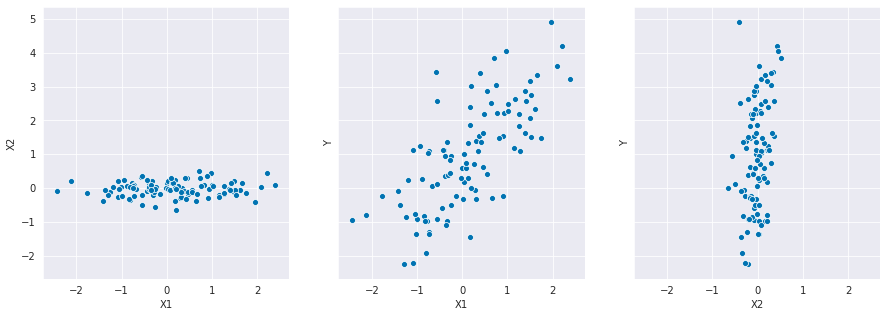

In [6]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))
sns.scatterplot(x=X[:, 0], y=X[:, 1], ax=axes[0])
axes[0].set_xlabel("X1")
axes[0].set_ylabel("X2")

sns.scatterplot(x=X[:, 0], y=Y.squeeze(), ax=axes[1])
axes[1].set_xlabel("X1")
axes[1].set_ylabel("Y")

sns.scatterplot(x=X[:, 1], y=Y.squeeze(), ax=axes[2])
axes[2].set_xlabel("X2")
axes[2].set_ylabel("Y")


plt.show()

## Define model

In [7]:
with pm.Model() as linear_model:
    # Priors for unknown parameters
    bias = pm.Normal("bias", mu=0, sigma=10)
    weights = pm.Normal("weights", mu=0, sigma=10, shape=2)
    epsilon = pm.HalfNormal("epsilon", sigma=1)
    
    # Expected value of outcome (i.e. linear function)
    mu = (X @ weights)[:, np.newaxis] + bias
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=epsilon, observed=Y)

## Fit model

### MAP

In [8]:
# Using L-BFGS-B
map_est = pm.find_MAP(model=linear_model)
map_est

logp = -155.36, ||grad|| = 12.881: 100%|██████████| 20/20 [00:00<00:00, 1995.62it/s]  


{'bias': array(0.88424182),
 'weights': array([1.10407373, 2.21914399]),
 'epsilon_log__': array(-0.04266357),
 'epsilon': array(0.95823371)}

In [12]:
# Using Powell's method
map_est = pm.find_MAP(model=linear_model, method="Powell")
map_est

  0%|          | 0/5000 [00:00<?, ?it/s]/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/scipy/optimize/_minimize.py:506: RuntimeWarning: Method Powell does not use gradient information (jac).
  RuntimeWarning)
logp = -148.47, ||grad|| = 1.0157: 100%|██████████| 217/217 [00:00<00:00, 3150.78it/s] 


{'bias': array(0.88622855),
 'weights': array([1.10621444, 2.22303144]),
 'epsilon_log__': array(-0.04066825),
 'epsilon': array(0.9601476)}

### Gradient-based sampling

In [13]:
with linear_model:
    trace = pm.sample(random_seed=rand_seed)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [epsilon, weights, bias]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 3534.12draws/s]


In [45]:
summary_df = pm.summary(trace, credible_interval=.95)
summary_df

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
bias,0.887,0.105,0.673,1.080,0.002,0.002,2340.0,2330.0,2330.0,1447.0,1.0
weights[0],1.106,0.100,0.911,1.309,0.002,0.002,2110.0,2110.0,2115.0,1647.0,1.0
weights[1],2.217,0.458,1.340,3.102,0.009,0.006,2770.0,2705.0,2756.0,1620.0,1.0
epsilon,0.986,0.071,0.852,1.125,0.001,0.001,2643.0,2556.0,2742.0,1464.0,1.0


## Posterior analysis

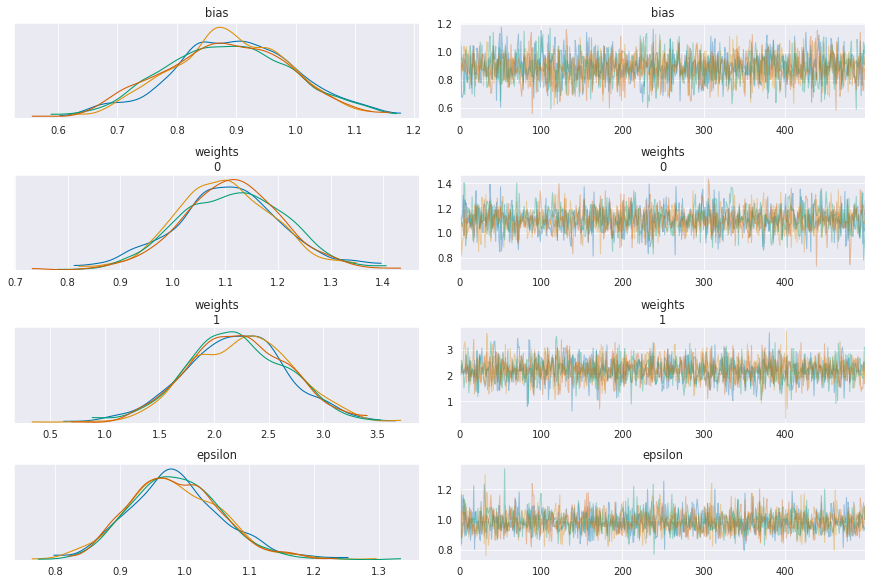

In [39]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    axes = pm.traceplot(trace, compact=False, show=False)
plt.show()